In [ ]:
# # cheking the number of cored this system has.
# !cat /proc/cpuinfo | grep "cpu cores" | uniq

# # GPU info
# !nvidia-smi

# # Amount of system RAM available to be used.
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
# print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

# #finding the recursion limit to avoid Augmentation recursion error 
# import sys
# print(sys.getrecursionlimit())

# #installing fastai
# !pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#importing libraries and initializing fastai 
import pandas as pd 
import numpy as np 
import time

#Mounting google drive for saving the models after training 
from google.colab import drive
drive.mount('/content/drive')

from fastai.vision import *
from fastai.metrics import error_rate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading the data 
#There are NaN values in the consumer_complaint_narrative column
train_raw = pd.read_csv('/content/drive/MyDrive/MS_Final_Project/Dataset_Ref/consumer_complaints.csv')
train_raw.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [ ]:
#Training data shape
train_raw.shape

(555957, 18)

In [ ]:
#Preprocessing the data 
#Extracting only those data whose consumer_complaint_narrative column is not null
#columns = 18
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

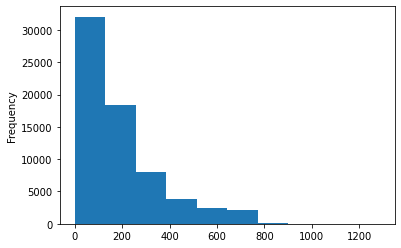

In [ ]:
#It splits the string into , separated values 
train_raw.consumer_complaint_narrative.apply(lambda x:len(x.split())).plot(kind='hist')

In [ ]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))

In [ ]:
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [ ]:
train_raw.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id', 'len_txt'],
      dtype='object')

In [ ]:
train_raw.shape

(66806, 19)

In [ ]:
#Select only the rows with more than 250 words 
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [ ]:
train_raw.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,len_txt
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524,666
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137,259
190251,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I spoke to XXXX of green tree representatives ...,NaN,Ditech Financial LLC,CA,948XX,NaN,Consent provided,Web,03/19/2015,Closed with non-monetary relief,Yes,No,1290534,301
190263,03/19/2015,Credit card,NaN,Other,NaN,i opened XXXX Bank of America credit cards 15-...,Company chooses not to provide a public response,Bank of America,OR,971XX,NaN,Consent provided,Web,03/19/2015,Closed with monetary relief,Yes,Yes,1292209,780
190264,03/19/2015,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,I applied for a loan with XXXX XXXX and had pu...,NaN,Hyundai Capital America,MS,392XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1292159,558


In [ ]:
#selecting only the consumer_complaint_narrative and product columns
train_raw=train_raw[['consumer_complaint_narrative','product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card', 'Consumer Loan', 'Debt collection', 'Credit reporting', 'Student loan',
       'Bank account or service', 'Money transfers', 'Payday loan', 'Prepaid card', 'Other financial service'],
      dtype=object)

In [ ]:
#group similar products  dataframe.at = accessing a value using row column pair 
train_raw.at[train_raw['product']=='Credit reporting','product']= 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card or prepaid card', 'Consumer Loan', 'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports', 'Student loan',
       'Bank account or service', 'Money transfers', 'Payday loan, title loan, or personal loan',
       'Other financial service'], dtype=object)

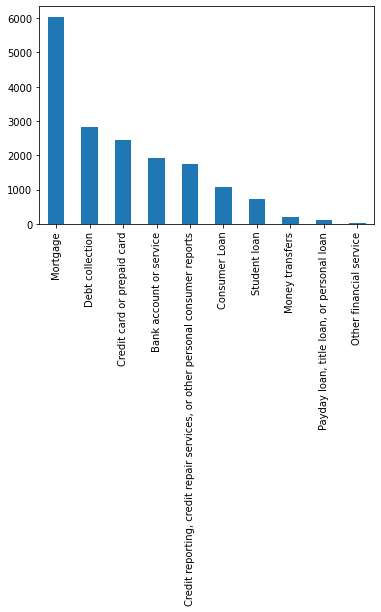

In [ ]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')
#unbalanced dataset 

In [ ]:
#Renaming the columns 
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
#changing the categorical value column to integers

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [ ]:
len(np.unique(train_raw['label']))

10

In [ ]:
#creating the copy of the dataframe
#dataframe.copy(deep=True)  ==> This will create a copy and any changes to the copy will not be reflected in the original df
train = train_raw.copy()

In [ ]:
#reindexing to create randomness 
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
14095,This matter involves the theft of my funds in ...,0
2835,"I spoke with a woman named "" XXXX '' at a comp...",4
11001,Wells Fargo Student Loans : I am a recent coll...,9
9895,I had a credit card account with my credit uni...,3
5590,I co-signed for a private education student lo...,9


In [ ]:
#remove the non-alphanumeric characters from the text 
import re 
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)     #() -- to match the sequence inside it , \-- to escape the special characters , 
                                     #\W -- get all the nonalphanumeric characters, + --all the instances 

  return text

In [ ]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
14095,This matter involves the theft of my funds in ...,0
2835,I spoke with a woman named XXXX at a company s...,4
11001,Wells Fargo Student Loans I am a recent colleg...,9
9895,I had a credit card account with my credit uni...,3
5590,I co signed for a private education student lo...,9


In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label
7379,1 FCI sent statements to an ambiguous address ...,6
11946,Hello CFPB I would like to bring to your atten...,6
892,American Educational Services has breached the...,9
10948,My wallet was stolen while at the airport XX X...,4
6070,I have had a US Bank mortgage loan since 2009 ...,6


In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,1 FCI sent statements to an ambiguous address ...,6
1,Hello CFPB I would like to bring to your atten...,6


In [ ]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label
0,Currently I am in debt with student loans of m...,9
1,I have been getting the run around from my len...,6


In [ ]:
val.shape, train.shape

((3429, 2), (13713, 2))

In [ ]:
#Installing the BERT module
!pip install bert-tensorflow
#!pip install bert-for-tf2

In [ ]:
import bert
from bert import optimization

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('CPU')))

In [ ]:
pip install -q tf-models-official==2.4.0

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


# Setting The Output Directory for BERT



In [ ]:
#Setting the output directory for BERT 
# Set the output directory for saving model file
OUTPUT_DIR = '/content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.DeleteRecursively(OUTPUT_DIR)#deletes everything under the directory recursively
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR) #Creates a directory and all parent/intermediate directories.
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail *****


In [ ]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (13713, 2)
Validation Set Shape : (3429, 2)


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Splitting the Data into smaller chunks

In [ ]:
#Splitting the data into smaller chunks 
# def get_split(text1):
#   l_total = []
#   l_parcial = []
#   if len(text1.split())//150 >0:
#     n = len(text1.split())//150
#   else: 
#     n = 1
#   for w in range(n):
#     if w == 0:
#       l_parcial = text1.split()[:200]
#       l_total.append(" ".join(l_parcial))
#     else:
#       l_parcial = text1.split()[w*150:w*150 + 200] #overlapping 50 words in every chunks 
#       l_total.append(" ".join(l_parcial))
#   return l_total

In [ ]:
# train['text_split'] = train[DATA_COLUMN].apply(get_split)
# train.head()

In [ ]:
# val['text_split'] = val[DATA_COLUMN].apply(get_split)
# val.head(2)

In [ ]:
# train_l = []
# label_l = []
# index_l =[]
# for idx,row in train.iterrows():
#   for l in row['text_split']:  #it is going to create list of training chunks with label and index mapping 
#     train_l.append(l)
#     label_l.append(row['label'])
#     index_l.append(idx)
# len(train_l), len(label_l), len(index_l)

In [ ]:

# val_l = []
# val_label_l = []
# val_index_l = []
# for idx,row in val.iterrows():
#   for l in row['text_split']:
#     val_l.append(l)
#     val_label_l.append(row['label'])
#     val_index_l.append(idx)
# len(val_l), len(val_label_l), len(val_index_l)

In [ ]:
# train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
# train_df.head()

In [ ]:
# train_df.shape

In [ ]:
# val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
# val_df.head()

# BERT: Data Preprocessing

In [ ]:
#BERT - Data Preprocessing
#//**Note-BELOW ONE IS NOT WORKING AS THE CLASS "INPUTEXAMPLE" IS PRESENT ONLY THE BERT-TENSORFLOW VERSION 1.0.1 **
#train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                       #            text_a = x[DATA_COLUMN], 
                                                       #            text_b = None, 
                                                       #            label = x[LABEL_COLUMN]), axis = 1)
#AttributeError: module 'official.nlp.bert.run_classifier' has no attribute 'InputExample'
#Getting the above error , so we are using an alternate method to create BERT dataframe 

#Reference : https://towardsdatascience.com/beginners-guide-to-bert-for-multi-classification-task-92f5445c2d7c

In [ ]:
#create a new dataframe for train, dev data 
#<DO NOT USE THIS ONE>
# train_InputExamples = pd.DataFrame({'guid': None,
#     'text_a': train_df[DATA_COLUMN],
#     'text_b': None,
#     'label': train_df[LABEL_COLUMN]})

In [ ]:
# train_InputExamples

In [ ]:

# print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
# print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
# print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
# print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

In [ ]:
#Second refrence 
#https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07E%20-%20Text%20Classification%20with%20BERT%20Deep%20Transfer%20Learning.ipynb#scrollTo=MZ-eiTcDZ6Jw

In [ ]:
train

,text,label
0,1 FCI sent statements to an ambiguous address ...,6
1,Hello CFPB I would like to bring to your atten...,6
2,American Educational Services has breached the...,9
3,My wallet was stolen while at the airport XX X...,4
4,I have had a US Bank mortgage loan since 2009 ...,6
...,...,...
13708,Bank of America XXXX XXXX XXXX XXXX and XXXX X...,6
13709,Hello We leased a little XXXX XXXX XXXX in XX ...,1
13710,So I have a Discover credit card On their onli...,2
13711,Homeowner received letter of collection from X...,4


In [ ]:
class PaddingInputExample(object):
      pass

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
train_InputExamples_1 = train.apply(lambda x: InputExample(guid=None,
                                                                  text_a = x[DATA_COLUMN], 
                                                                  text_b = None, 
                                                                  label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples_1

0        <__main__.InputExample object at 0x7f15cad9c0d0>
1        <__main__.InputExample object at 0x7f15cad9c210>
2        <__main__.InputExample object at 0x7f15cad9c150>
3        <__main__.InputExample object at 0x7f15cad9ce50>
4        <__main__.InputExample object at 0x7f15cad9ca10>
                               ...                       
13708    <__main__.InputExample object at 0x7f15caa54390>
13709    <__main__.InputExample object at 0x7f15caa543d0>
13710    <__main__.InputExample object at 0x7f15caa54410>
13711    <__main__.InputExample object at 0x7f15caa54450>
13712    <__main__.InputExample object at 0x7f15caa54490>
Length: 13713, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples_1.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples_1.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples_1.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples_1.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  1 FCI sent statements to an ambiguous address XXXX XXXX in XXXX it was not listed on any applications 2 They never sent any communication to the property address 3 We received the first statement from this company in XXXX 2015 after providing both the property address and an updated XXXX XXXX for billing TODAY THEY RETURNED A CHECK SAYING DUE TO A FORECLOSURE IN PROCESS In XXXX 2015 we obtained a mortgage with XXXX XXXX XXXX Loan NoXXXX The loan documents XXXX attached XXXX states that payments should be made to FCI Lender Services Inc located in XXXX We have sent payments to this address successfully using the loan number above until XXXX 2015 After sending check No XXXX on XXXX XXXX 2015 we were informed on or about XXXX XXXX 2015 that payment was not received In following up on this notification with FCI Customer Service on XXXX XXXX 2015 we found that the Loan No XXXX did not exist in FCI s system we

In [ ]:
val_InputExamples_1 = val.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

# BERT: Loading the pre-trained model

In [ ]:
# import tensorflow.compat.v1 as tf
# #To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
# tf.disable_eager_execution()

In [ ]:
##We are creatung the tokens to gorm the vocabulary which inturn is ued to represent the words
#BERT: Loading the pre-trained model
# bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

# vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [ ]:
#len(tokenizer.vocab.keys())

In [ ]:
#Here is what the tokenised sample of the first training set observation looks like
#print(tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))

In [ ]:
#BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [ ]:
import official.nlp.bert.tokenization as tokenization

In [ ]:
# ##We are creatung the tokens to gorm the vocabulary which inturn is ued to represent the words
# #BERT: Loading the pre-trained model
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.compat.v1.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
print(tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))

['1', 'fc', '##i', 'sent', 'statements', 'to', 'an', 'ambiguous', 'address', 'xx', '##xx', 'xx', '##xx', 'in', 'xx', '##xx', 'it', 'was', 'not', 'listed', 'on', 'any', 'applications', '2', 'they', 'never', 'sent', 'any', 'communication', 'to', 'the', 'property', 'address', '3', 'we', 'received', 'the', 'first', 'statement', 'from', 'this', 'company', 'in', 'xx', '##xx', '2015', 'after', 'providing', 'both', 'the', 'property', 'address', 'and', 'an', 'updated', 'xx', '##xx', 'xx', '##xx', 'for', 'billing', 'today', 'they', 'returned', 'a', 'check', 'saying', 'due', 'to', 'a', 'fore', '##cl', '##os', '##ure', 'in', 'process', 'in', 'xx', '##xx', '2015', 'we', 'obtained', 'a', 'mortgage', 'with', 'xx', '##xx', 'xx', '##xx', 'xx', '##xx', 'loan', 'no', '##xx', '##xx', 'the', 'loan', 'documents', 'xx', '##xx', 'attached', 'xx', '##xx', 'states', 'that', 'payments', 'should', 'be', 'made', 'to', 'fc', '##i', 'lend', '##er', 'services', 'inc', 'located', 'in', 'xx', '##xx', 'we', 'have', 'sen

In [ ]:
#Defining Input features 
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
      # TRUNCATION ---> HEAD + TAIL
        tokens_a = tokens_a[:128] + tokens_a[-(max_seq_length - 2 - 128):]
      # ORIGINAL
        # tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.
# train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples_1, label_list, MAX_SEQ_LENGTH, tokenizer)

# val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples_1, label_list, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=200):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels,features = [], [], [], [],[]
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )

        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

        feature = InputFeatures(input_ids=input_id,
        input_mask=input_mask,
        segment_ids=segment_id,
        label_id=label,
        is_real_example=True)

        features.append(feature)
    # return(
    #     np.array(input_ids),
    #     np.array(input_masks),
    #     np.array(segment_ids),
    #     np.array(labels).reshape(-1, 1),
    # )
    return features

In [ ]:
import tqdm

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.
MAX_SEQ_LENGTH = 200
train_features = convert_examples_to_features(tokenizer, train_InputExamples_1, MAX_SEQ_LENGTH)

val_features = convert_examples_to_features(tokenizer, val_InputExamples_1, MAX_SEQ_LENGTH)

Converting examples to features: 100%|██████████| 3429/3429 [00:26<00:00, 131.68it/s]


In [ ]:
print("Sentence : ", train_InputExamples_1.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  1 FCI sent statements to an ambiguous address XXXX XXXX in XXXX it was not listed on any applications 2 They never sent any communication to the property address 3 We received the first statement from this company in XXXX 2015 after providing both the property address and an updated XXXX XXXX for billing TODAY THEY RETURNED A CHECK SAYING DUE TO A FORECLOSURE IN PROCESS In XXXX 2015 we obtained a mortgage with XXXX XXXX XXXX Loan NoXXXX The loan documents XXXX attached XXXX states that payments should be made to FCI Lender Services Inc located in XXXX We have sent payments to this address successfully using the loan number above until XXXX 2015 After sending check No XXXX on XXXX XXXX 2015 we were informed on or about XXXX XXXX 2015 that payment was not received In following up on this notification with FCI Customer Service on XXXX XXXX 2015 we found that the Loan No XXXX did not exist in FCI s system we used the property address to look up the account We were told that 1 X

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1]

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

(857, 10)

In [ ]:
#Initializing the model and the estimator   <USE THIS BLOCK IF YOU ARE TRAINING FOR THE FIRST TIME>
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
import datetime

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#BERT: Fine Tuning Training & Evaluating
print(f'Beginning Training!')
#current_time = datetime.time()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
#print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.444219, step = 0


INFO:tensorflow:loss = 2.444219, step = 0
INFO:tensorflow:global_step/sec: 1.9557


INFO:tensorflow:loss = 0.7215365, step = 100 (51.135 sec)


INFO:tensorflow:loss = 0.7215365, step = 100 (51.135 sec)


INFO:tensorflow:global_step/sec: 2.47598


INFO:tensorflow:global_step/sec: 2.47598


INFO:tensorflow:loss = 0.5792246, step = 200 (40.389 sec)


INFO:tensorflow:loss = 0.5792246, step = 200 (40.389 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:global_step/sec: 2.14953


INFO:tensorflow:global_step/sec: 2.14953


INFO:tensorflow:loss = 0.3126719, step = 300 (46.521 sec)


INFO:tensorflow:loss = 0.3126719, step = 300 (46.521 sec)


INFO:tensorflow:global_step/sec: 2.47524


INFO:tensorflow:global_step/sec: 2.47524


INFO:tensorflow:loss = 0.5814335, step = 400 (40.401 sec)


INFO:tensorflow:loss = 0.5814335, step = 400 (40.401 sec)


INFO:tensorflow:global_step/sec: 2.47733


INFO:tensorflow:global_step/sec: 2.47733


INFO:tensorflow:loss = 0.30589926, step = 500 (40.367 sec)


INFO:tensorflow:loss = 0.30589926, step = 500 (40.367 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:global_step/sec: 2.16604


INFO:tensorflow:global_step/sec: 2.16604


INFO:tensorflow:loss = 0.59128785, step = 600 (46.166 sec)


INFO:tensorflow:loss = 0.59128785, step = 600 (46.166 sec)


INFO:tensorflow:global_step/sec: 2.4743


INFO:tensorflow:global_step/sec: 2.4743


INFO:tensorflow:loss = 0.4198633, step = 700 (40.417 sec)


INFO:tensorflow:loss = 0.4198633, step = 700 (40.417 sec)


INFO:tensorflow:global_step/sec: 2.47842


INFO:tensorflow:global_step/sec: 2.47842


INFO:tensorflow:loss = 0.61934173, step = 800 (40.348 sec)


INFO:tensorflow:loss = 0.61934173, step = 800 (40.348 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 857...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 857...


INFO:tensorflow:Saving checkpoints for 857 into /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt.


INFO:tensorflow:Saving checkpoints for 857 into /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 857...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 857...


INFO:tensorflow:Loss for final step: 0.20389989.


INFO:tensorflow:Loss for final step: 0.20389989.


In [ ]:
# #Run this If you want to load the model 
# #Loading a specific check point : 
warm_start = tf.estimator.WarmStartSettings(ckpt_to_initialize_from='/content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt-857.meta')


model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator=tf.estimator.Estimator(model_fn=model_fn,
                       config=run_config,
                       params={"batch_size": BATCH_SIZE},
                       warm_start_from=warm_start)

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
#Evaluation of the BERT model
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-10-01T20:48:20


INFO:tensorflow:Starting evaluation at 2021-10-01T20:48:20


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt-857


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt-857


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 34.12939s


INFO:tensorflow:Inference Time : 34.12939s


INFO:tensorflow:Finished evaluation at 2021-10-01-20:48:54


INFO:tensorflow:Finished evaluation at 2021-10-01-20:48:54


INFO:tensorflow:Saving dict for global step 857: eval_accuracy = 0.9101779, false_negatives = 57.0, false_positives = 47.0, global_step = 857, loss = 0.33503047, true_negatives = 338.0, true_positives = 2987.0


INFO:tensorflow:Saving dict for global step 857: eval_accuracy = 0.9101779, false_negatives = 57.0, false_positives = 47.0, global_step = 857, loss = 0.33503047, true_negatives = 338.0, true_positives = 2987.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 857: /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt-857


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 857: /content/drive/MyDrive/MS_Final_Project/without_chunks/CC_truncate_head_tail/model.ckpt-857


{'eval_accuracy': 0.9101779,
 'false_negatives': 57.0,
 'false_positives': 47.0,
 'global_step': 857,
 'loss': 0.33503047,
 'true_negatives': 338.0,
 'true_positives': 2987.0}